WEINER FILTERING

Improvements aimed for next week: 

- The length and angle of the kernel calculated by this code is often not correct and gives the wrong results, so the deblurring parameters have been set manually for each image
- For images with more than one rain streak, this code only calculates the kernel for the longest rain streak



(480, 640)
(480, 640, 3)
135
Estimated motion blur: length=50, angle=135.00


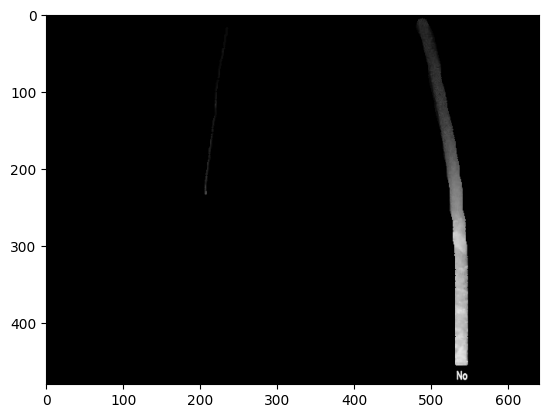

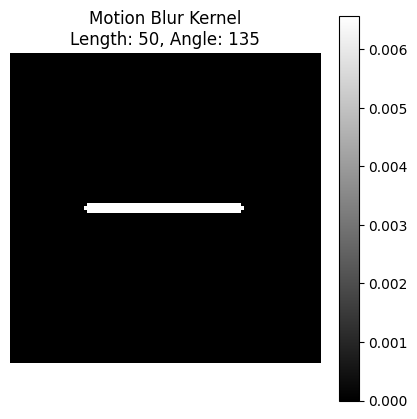

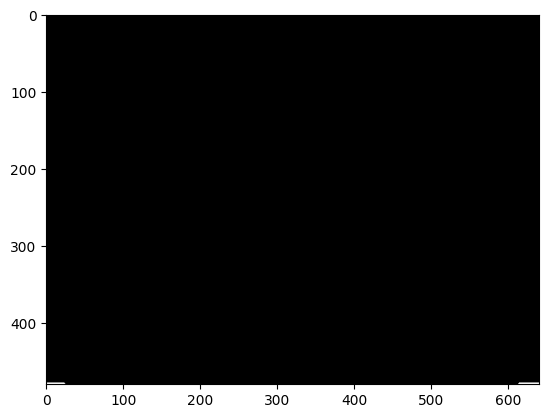

In [ ]:
import cv2
import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import radon
from scipy.signal import find_peaks



def estimate_blur_parameters(masked_img_gray):
    edges = cv2.Canny(masked_img_gray, 50, 150)

    # Radon Transform to estimate angle
    theta = np.arange(0, 180, 1)
    sinogram = radon(edges, theta=theta, circle=False)
    angle = theta[np.argmax(np.sum(sinogram, axis=0))]

    print(angle)

    # if angle > 90:
    #     angle -= 180
    # angle = (angle + 90) % 180

    # Estimate blur length using FFT
    fft = np.fft.fftshift(np.abs(np.fft.fft2(edges)))
    profile = np.mean(fft, axis=0)
    peaks, _ = find_peaks(profile, height=np.max(profile) * 0.5)
    length = abs(peaks[-1] - peaks[0]) if len(peaks) >= 2 else 15
    return max(5, min(length, 50)), angle


def motion_blur_kernel(length, angle, size):
    kernel = np.zeros((size, size), np.float32)
    center = size // 2
    angle_rad = np.deg2rad(angle)
    x1 = int(center - (length - 1) / 2 * np.cos(angle_rad))
    y1 = int(center - (length - 1) / 2 * np.sin(angle_rad))
    x2 = int(center + (length - 1) / 2 * np.cos(angle_rad))
    y2 = int(center + (length - 1) / 2 * np.sin(angle_rad))
    cv2.line(kernel, (x1, y1), (x2, y2), 1, thickness= 2)
    kernel /= kernel.sum()
    return kernel


def inverse_filtering(blurred_img, kernel):
    blurred = blurred_img.astype(np.float32) / 255.0
    h, w = blurred.shape[:2]

    kernel_padded = np.zeros((h, w), dtype=np.float32)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel
    kernel_padded = np.roll(kernel_padded, -kh//2, axis=0)
    kernel_padded = np.roll(kernel_padded, -kw//2, axis=1)

    restored = np.zeros_like(blurred)
    eps = 1e-3  # small value to avoid division by zero

    for c in range(3):
        fft_blurred = np.fft.fft2(blurred[:, :, c])
        fft_kernel = np.fft.fft2(kernel_padded)
        fft_restored = fft_blurred / (fft_kernel + eps)
        restored[:, :, c] = np.abs(np.fft.ifft2(fft_restored))

    return np.clip(restored * 255, 0, 255).astype(np.uint8)


def wiener_filter(image, kernel, K=0.01):
    image = image.astype(np.float32) / 255.0
    h, w = image.shape[:2]
    
    

    # Pad kernel
    kernel_padded = np.zeros((h, w), dtype=np.float32)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    kph , kpw = kernel_padded.shape[:2]

    # kernel_padded = np.roll(kernel_padded, (kph - kh)//2 , axis=0)
    # kernel_padded = np.roll(kernel_padded, (kpw - kw)//2, axis=1)

    kernel_padded = np.roll(kernel_padded, - kh//2 , axis=0)
    kernel_padded = np.roll(kernel_padded, - kw//2, axis=1)




   
    plt.imshow(kernel_padded, cmap='gray')
    

    fft_kernel = np.fft.fft2(kernel_padded)
    restored = np.zeros_like(image)

    for c in range(3):
        fft_img = np.fft.fft2(image[:, :, c])
        H_conj = np.conj(fft_kernel)
        H_abs2 = np.abs(fft_kernel) ** 2
        fft_restored = H_conj / (H_abs2 + K) * fft_img
        restored[:, :, c] = np.abs(np.fft.ifft2(fft_restored))

    return np.clip(restored * 255, 0, 255).astype(np.uint8)

# === MAIN SCRIPT ===

# Load image and mask
rainy_image = cv2.imread("E:/Uni/Summer' 25/Deblurring/Images/rainy_image1.jpg")
rain_mask = cv2.imread("E:/Uni/Summer' 25/Deblurring/Masks/rainy_mask1.png", cv2.IMREAD_GRAYSCALE)


rain_mask = cv2.resize(rain_mask, (rainy_image.shape[1], rainy_image.shape[0]))

# print(rain_mask.shape)
# print(rainy_image.shape)

# Threshold mask to binary (just in case)
rain_mask = (rain_mask > 127).astype(np.uint8)

# Extract rain-only region
rainy_only = cv2.bitwise_and(rainy_image, rainy_image, mask=rain_mask)

plt.imshow(rainy_only)

# Estimate blur parameters
# gray_rain = cv2.cvtColor(rainy_only, cv2.COLOR_BGR2GRAY)
length, angle = estimate_blur_parameters(rainy_only)
print(f"Estimated motion blur: length={length}, angle={angle:.2f}")

# Create blur kernel
kernel_size = int(2 * round(length) + 1)


kernel = motion_blur_kernel(50, 0, kernel_size)

plt.figure(figsize=(5, 5))
plt.imshow(kernel, cmap='gray')
plt.title(f'Motion Blur Kernel\nLength: {length}, Angle: {angle}')
plt.colorbar()
plt.axis('off')
plt.show()

# Apply Wiener filter
deblurred_full = wiener_filter(rainy_image, kernel)

# Feather mask
feathered_mask = cv2.GaussianBlur(rain_mask.astype(np.float32), (21, 21), 0)

# Blend the deblurred result only on rain regions
final_output = rainy_image.copy()
for c in range(3):
    final_output[:, :, c] = (
        deblurred_full[:, :, c] * feathered_mask +
        rainy_image[:, :, c] * (1 - feathered_mask)
    ).astype(np.uint8)

# Show result
cv2.imshow("Deblurred Rain", final_output)
cv2.waitKey(0)
cv2.destroyAllWindows()


Some results

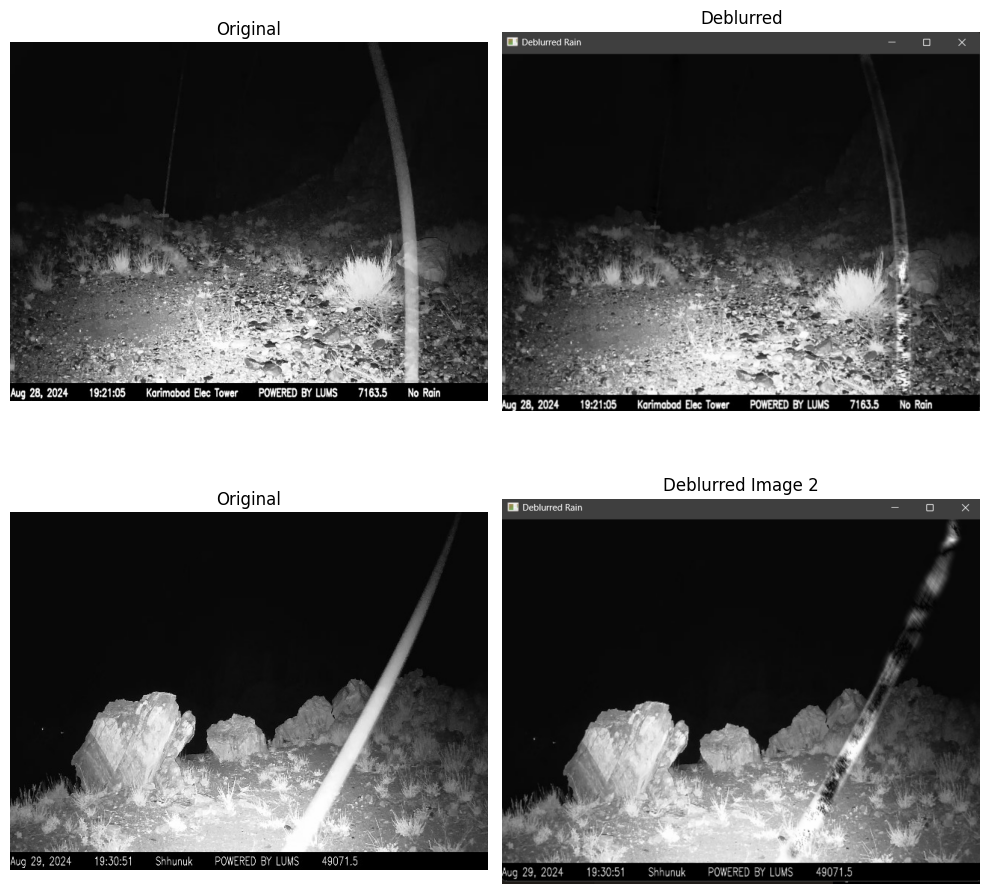

In [13]:

Orig_img1 = cv2.imread("E:/Uni/Summer' 25/Deblurring/Images/rainy_image1.jpg")
Orig_img2 = cv2.imread("E:/Uni/Summer' 25/Deblurring/Images/rainy_image2.jpg")


Deblurred_img1 = cv2.imread("E:/Uni/Summer' 25/Deblurring/Images/Deblurred_best.png")
Deblurred_img2 = cv2.imread("E:/Uni/Summer' 25/Deblurring/Images/Deblurred_2_1.png")


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(Orig_img1)
plt.title("Original")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(Deblurred_img1)
plt.title("Deblurred")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(Orig_img2)
plt.title("Original")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(Deblurred_img2)
plt.title("Deblurred Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()
